# Basics

In [ ]:
# hide
import sys
sys.path.append("..")

In [ ]:
# export
# default_exp basics
import SimpleITK as sitk
import torchvision
from torch import Tensor
from fastai.basics import *

## Why a new Class?
Fastai 2 provides support to read and display medical images using pydicom and pillow, however only 2D images can be read. So no direct support of 3D volumes is given in fastai. Furthermore, fastai only allows to read DICOM 2D images, not volumes, DICOM Series or any of the other medical formats such as NIfTI, NRRD, ....  For effective work with medical data, all possible formats should be supported. Therefore, in `faimed3d` [SimpleITK](https://simpleitk.org/)  is used to read images. SimpleITK is a powerfull library which can handle many data formats, including all of the above mentioned and many more. It is widely used for medical applications and very fast, as it is written in pure C++.  
To allow specific augmentations, only to 3D data, two new classes are used in `faimed3d`: `TensorDicom3D` for 3D image volumes and `TensorMask3D` for segmentation masks. Both are subclasses to `torch.Tensor`. A basic support for Header information will be implemented in both classes, as the header sometimes has important information, e.g. for re-scaling of the pixel values, pixel spacing or patient orientation. 


## Reading medical files with TensorDicom3D

In [ ]:
# export
class TensorDicom3D(Tensor):
    "Base class for 3D medical images"
    def __init__(self, *args, **kwargs):
        super().__init__()    
        if not hasattr(self, 'metadata'): self.init_metadata()
        
    def init_metadata(self):
        self.metadata = self.create_metadata()
        self.metadata['spacing'] = (1,1,1)
        self.metadata['origin'] = (0,0,0)
        self.metadata['direction'] = (1,0,0, 0,1,0, 0,0,1)
    
    @staticmethod
    def create_metadata():
        "creates a rudimetary dict with metadata, to allow conversion as a sitk.Image"
        return {
            'table': pd.DataFrame({'tags': ['0008|103E'], # cannot pass an empty header to write function, thus add a series description.
                                   'value': ['Object generated from PyTorch `Tensor`. Spacing, origin and direction might be wrong']})
        }
    
    @classmethod
    def create(cls, fn:(Path,str,Tensor,ndarray), load_header=False,  **kwargs):
        """
        Open an `3D Image` from path `fn` or create it from an array
        Args: 
            cls: Class of the object to create. Should be either TensorDicom3D or TensorMask3D
            fn:  Filename of the medical image file. String or `pathlib.Path`
        Returns: 
            An instance of `cls`
        """
        if isinstance(fn,ndarray): return cls(fn)
        if isinstance(fn, Tensor): return cls(fn)
        instance, metadata = TensorDicom3D.load(fn,load_header)
        instance = cls(instance)
        instance.metadata = metadata
        instance.fn = str(fn)
        return instance
        
    @staticmethod
    def load(fn: (Path, str), load_header:bool):
        """
        Loads a Medical image file. Stores pixel information as `Tensor` and DICOM header as dictionary. 
        Args: 
            fn:  Filename of the medical image file. String or `pathlib.Path`
            metadata_for_all_slices: if a DICOM series is given, if metadata from every single elemt of the series should be read. 
            
        Returns: 
            A tuple. 1st element is the pixelvalues converted to a `Tensor`, 2nd element is the metadata as dict. 
        Process:    
           [load pixel array] -> [load basic metadata] -> [load image header] -> [return]
    
            load pixel array: 
                Medical images can be presented as a single volumetric file or as a (DICOM)-series.
                If `fn` points to a directory, it is assumed that a DICOM series should be loaded. 
                If `fn` is a file, it is assumed it is a single 3D Volume. 
                
            load basic meta data: 
                Spacing, origin and direction are important for image display and calulations. 
                They are stored seperatly. 
                
            load image header (optional): 
                creates table with header information. 
                For most purposes, the header information is not needed, and just takes time to load. 
                Is thus turned off by default. 
                
                | tags      | fn_01                        | fn_02             | ...
                |-----------|------------------------------|-------------------|----
                | DICOM tag | name of file or of 1st slice | name of 2nd slice | ...
                
                Some tags contain special characters, which are transformed to surrogates. 
                This will lead to failure when displaying or writing the metadata. 
                Using encode(errors='ignore').decode() the surrogates are removed and the string ist turned into a bytes object.
                Using decode will turn the bytes back into a string.  
        """
        # Initialize metadata
        metadata = TensorDicom3D.create_metadata()
        
        # read volume
        if isinstance(fn, str): fn = Path(fn)
        if fn.is_dir(): im = TensorDicom3D.read_dicom_series(str(fn))
        elif fn.is_file(): im = sitk.ReadImage(str(fn), outputPixelType=sitk.sitkFloat32)
        else: raise TypeError('the path "{}" is neither a valid directory nor a file'.format(str(fn)))
        # set basic metadata
        metadata['spacing'] = im.GetSpacing()
        metadata['origin'] = im.GetOrigin()
        metadata['direction'] = im.GetDirection()
        if load_header: metadata['table'] = TensorDicom3D.read_extended_metadata(fn)
        return (torch.tensor(sitk.GetArrayFromImage(im)), metadata)
    
    @staticmethod
    def read_extended_metadata(fn:Path):
        "read metadata from file or Series and returns a pd.DataFrame"
        if fn.is_dir(): 
            # iter through slices, collecting remaining metadata 
            SeriesReader = sitk.ImageSeriesReader()            
            dicom_names = SeriesReader.GetGDCMSeriesFileNames(str(fn))
            reader = sitk.ImageFileReader()
            reader.SetFileName(dicom_names[0])
            reader.ReadImageInformation()
            slice_metadata=pd.DataFrame({'tags': reader.GetMetaDataKeys()})
            for dcm in dicom_names:  
                reader.SetFileName(dcm)
                reader.ReadImageInformation()
                try: 
                    slice_metadata[dcm] = [reader.GetMetaData(k).encode(encoding='UTF-8',errors='ignore')
                                                                .decode() for k in reader.GetMetaDataKeys()]
                except: 
                    print('Failed loading metadata for {}'.format(dcm))
            return slice_metadata
        
        if fn.is_file():
            return pd.DataFrame({'tags': im.GetMetaDataKeys(), 
                                 str(fn): [im.GetMetaData(k).encode(encoding='UTF-8',errors='ignore')
                                                            .decode() for k in im.GetMetaDataKeys()]})    

    @staticmethod
    def read_dicom_series(fn:str):
        """load a DICOM series as 3D volume."""
        SeriesReader = sitk.ImageSeriesReader()            
        dicom_names = SeriesReader.GetGDCMSeriesFileNames(str(fn))
        SeriesReader.SetFileNames(dicom_names)
        im = SeriesReader.Execute()        
        return sitk.Cast(im, sitk.sitkFloat32)
        
    def as_sitk(self):
        "convertes Tensor to SimpleITK image"
        im = sitk.GetImageFromArray(self.detach().cpu().numpy())
       # also save metadata        
        im.SetSpacing(self.metadata['spacing'])
        im.SetDirection(self.metadata['direction'])
        im.SetOrigin(self.metadata['origin'])
        for i in range(0, len(self.metadata['table'])):
            try: im.SetMetaData(self.metadata['table'].iloc[i,0], self.metadata['table'].iloc[i,1])
            except: print('failed to write DICOM tag {} : {}'.format(self.metadata['table'].iloc[i,0], self.metadata['table'].iloc[i,1]))
        return im
        
    def save(self, fn:str):
        im = self.as_sitk()
        sitk.WriteImage(im, fn)

In [ ]:
# export
class TensorMask3D(TensorDicom3D):
    "Base class for 3d Segmentation, inherits from TensorDicom3D"
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

In [ ]:
fn = '/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM'
im = TensorDicom3D.create(fn, load_header=True)
im.metadata['table']

,tags,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0030.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0029.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0028.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0027.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0026.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0025.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0024.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0023.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0022.dcm,...,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0009.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0008.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0007.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0006.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0005.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0004.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0003.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0002.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0001.dcm,/media/ScaleOut/prostata/data/dcm/A0042197734/T2/DICOM/0000.dcm
0,0008|0005,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,...,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100
1,0008|0008,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,...,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT,ORIGINAL\PRIMARY\M\NORM\DIS2D\SH\FIL\MFSPLIT
2,0008|0012,20181205,20181205,20181205,20181205,20181205,20181205,20181205,20181205,20181205,...,20181205,20181205,20181205,20181205,20181205,20181205,20181205,20181205,20181205,20181205
3,0008|0013,201257.045534,201256.875414,201256.721304,201256.560189,201256.394070,201256.231956,201256.069840,201255.909727,201255.739605,...,201254.137467,201254.029389,201253.915308,201253.788218,201253.668132,201253.541042,201253.412951,201253.284860,201253.132752,201253.012667
4,0008|0016,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,...,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4,1.2.840.10008.5.1.4.1.1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0040|0245,155756.000000,155756.000000,155756.000000,155756.000000,155756.000000,155756.000000,155756.000000,155756.000000,155756.000000,...,155756.000000,155756.000000,155756.000000,155756.000000,155756.000000,155756.000000,155756.000000,155756.000000,155756.000000,155756.000000
103,0040|0253,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,...,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb5f61ffe5db942,SIb

### Handlers for Metadata

_TODO: metadata is lost after indexing. How to keep Tensor attributes?_

In [ ]:
# export
@patch
def set_spacing(t:(TensorDicom3D,TensorMask3D), spacing):
    if isinstance(spacing, tuple) and len(spacing) == 3:
        t.metadata['spacing'] = spacing
    else:  raise ValueError('Spacing must be a tuple of length 3, but got {}'.format(spacing))

@patch
def get_spacing(t:(TensorDicom3D,TensorMask3D)): return t.metadata['spacing'] 

@patch
def set_origin(t:(TensorDicom3D,TensorMask3D), origin):
    if isinstance(origin, tuple) and len(origin) == 3:
        t.metadata['origin'] = origin
    else: raise ValueError('Origin must be a tuple of length 3, but got {}'.format(spacing))
        
@patch
def get_origin(t:(TensorDicom3D,TensorMask3D)): return t.metadata['origin'] 

@patch       
def set_direction(t:(TensorDicom3D,TensorMask3D), direction):
    if isinstance(direction, tuple) and len(direction) == 9:
        t.metadata['direction'] = direction
    else: raise ValueError('Direction must be a tuple of length 3, but got {}'.format(spacing))
        
@patch
def get_origin(t:(TensorDicom3D,TensorMask3D)): return t.metadata['origin'] 

## Display 3D images

Function to display the 3D volume in axial, coronal o

In [ ]:
# export
def show_image_3d(t: (np.ndarray, Tensor), axis: int = 0, figsize: int = (15,15), cmap: str = 'bone', nrow: int = 10, alpha = 1., return_grid = False, add_to_existing = False, **kwargs):
    '''
    Plots 2D slices of a 3D image alongside a prior specified axis. 
    Args: 
        t: a 3D numpy.ndarray or torch.Tensor 
        axis: axis to split 3D array to 2D images
        figsize, cmap: passed to plt.imshow
        nrow: passed to torchvision.utils.make_grid
        return_grid: Whether the grid should be returned for further processing or if the plot should be displayed. 
        add_to_existing: if set to true, no new figure will be created. Used for mask overlays
    '''
    if t.device.type == 'cuda': t=t.cpu()      
    if t.ndim < 3 or t.ndim > 4: 
         raise TypeError('Object is not a rank 3 tensor but a rank {} tensor'.format(t.ndim ))
    if t.ndim == 4: 
        warn('Object is not a rank 3 tensor but a rank {} tensor. Removing the first dimension'.format(t.ndim))
        t = t[0]
    if isinstance(t, np.ndarray): t = tensor(t)
    # TODO: is there a nicer more flexible way to adapt the axis?
    if axis == 1: t = t.permute(1, 0, 2)
    elif axis == 2: t = t.permute(2, 0, 1)
        
    # TODO: is there a better way to visualize the images?
    if t.min() < 0.: t = t-t.min() # shift pixelvalues to positive range, otherwise the negative values will be clipped. 
    t = t.unsqueeze(1)/torch.max(t) # rescale the images, makes for a nicer plot 
    grid = torchvision.utils.make_grid(t, nrow = nrow)
    if return_grid: return grid
    if not add_to_existing: plt.figure(figsize=figsize)
    plt.imshow(grid[0,:,:], cmap = cmap, alpha = alpha)

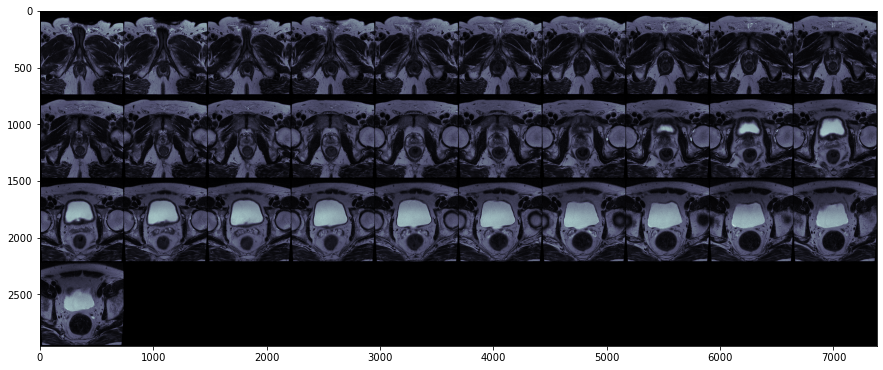

In [ ]:
show_image_3d(im, axis = 0, nrow = 10)

Sometimes multiple 3D images (e.g. a batch) need to be displayed. With a wrapper for `show_image_3d` this is conveniently possible.  

In [ ]:
# export
def show_images_3d(t: Tensor, axis: int = 0, figsize: int = (15,15), cmap: str = 'bone', nrow: int = 10, alpha = 1., return_grid = False, add_to_existing=False, **kwargs):
    "displays multiple 3D images (e.g. a batch) by flattening the 4th dimension of the tensor and then calling show_image_3d"    
    if t.ndim not in (4,5): raise TypeError('Object is not a rank 4 or rank 5 tensor but a rank {} tensor'.format(t.ndim))
    if axis > 2: raise ValueError('Axis should be between 0-2, indexing the plane to display each of the multiple 3D images. But axis was {}'.format(axis))

    if t.ndim == 4: t =t.reshape(t.size(0)*t.size(1), t.size(2), t.size(3))
    if t.ndim == 5: 
        t = t.permute(1,0,2,3,4)
        t =t.reshape(t.size(0), t.size(1)*t.size(2), t.size(3), t.size(4))
    if return_grid: return t
    show_image_3d(t, axis = axis, figsize = figsize, cmap = cmap, nrow = nrow, alpha = alpha, add_to_existing = add_to_existing)
    

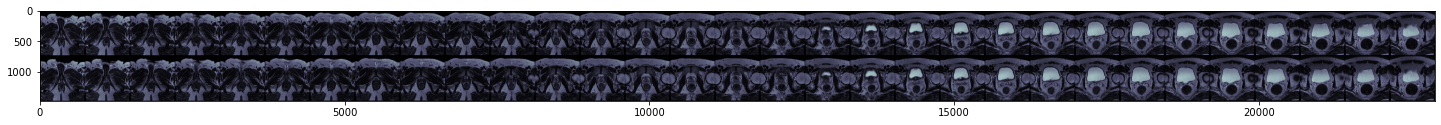

In [ ]:
show_images_3d(torch.stack((im,im)), axis = 0, nrow = 31, figsize = (25, 15))

In [ ]:
# export
@patch
def show(t:Tensor, axis: int = 0, figsize: int = (15,15), cmap: str = 'bone', nrow: int = 10, **kwargs):
    "displays the 3D image as a mosaik"
    if t.ndim == 3: return show_image_3d(t, axis = axis, figsize=figsize, cmap=cmap, nrow=nrow, return_grid = False, **kwargs)
    if t.ndim in (4,5): return show_images_3d(t, axis = axis, figsize=figsize, cmap=cmap, nrow=nrow, return_grid = False, **kwargs)

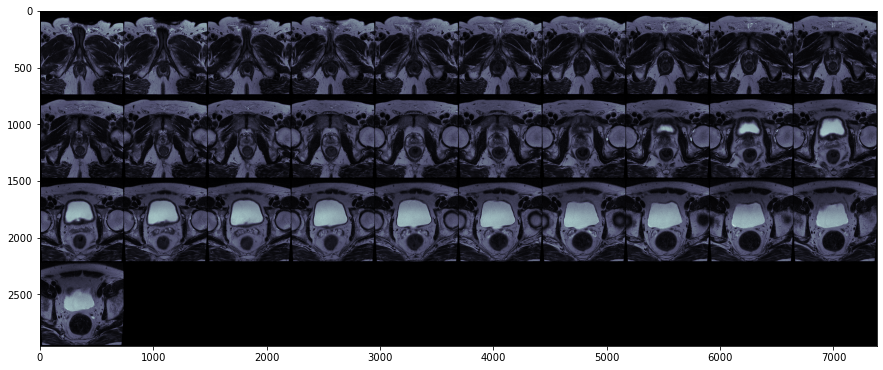

In [ ]:
im.show()

## Scale and Normalize images

Especially for MRI the pixel values can vary between scanner types. However, the imagenet stats, as provided by fastai should probably not be used, as they are specfic for color images and not MRI images. The optimal solution would probably be to calculate the stats on the present dataset. 

Statistics of intensity values, pooled across the whole training dataset (raw, unscaled pixel values and pixel values scaled between 0 and 1)

| Statistic                            | ADC       | T2          | T1 map   |
|--------------------------------------|-----------|-------------|----------|
| Pooled Maximum of intensity values   | 3064.2500 | 1369.5652   | 4095     |
| Pooled Minimum of intensity values   | 0.        | 0.          | 0.       |
| Pooled Mean of intensity values      | 511.1060  | 259.1454    | 740.8268 |
| Pooled SD of intensity values        | 488.8707  | 190.2448    | 688.8238 |
| Scaled Maximum of intensity values   | 1.        | 1.          | 1.       |
| Scaled Minimum of intensity values   | 0.        | 0.          | 0.       |
| Scaled Mean of intensity values      | 0.1675    | 0.1918      | 0.1809   |
| Scaled SD of intensity values        | 0.1599    | 0.1409      | 0.1682   |


However, just scaling wiht one mean and std might not be the optimal solution (see the excelent [Kaggle kernel](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai) form Jeremy Howard why). Although for MRI images it might be ok, as the pixel values are closer together.

### Histogram scaling

In [ ]:
im1 = TensorDicom3D(im[10:20])

In [ ]:
# export 
@patch
def freqhist_bins(t:(TensorDicom3D,Tensor), n_bins=100):
    '''
    A function to split the range of pixel values into groups, such that each group has around the same number of pixels. 
    taken from https://github.com/fastai/fastai/blob/master/fastai/medical/imaging.py#L78
    '''
    imsd = t.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(t:(TensorDicom3D,Tensor), brks=None):
    '''
    Scales a tensor using `freqhist_bins` to values between 0 and 1
    taken from https://github.com/fastai/fastai/blob/master/fastai/medical/imaging.py#L78
    '''
    if t.device.type=='cuda': return t.hist_scaled_pt(brks)
    if brks is None: brks = t.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = t.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    x = tensor(x).reshape(t.shape).clamp(0.,1.)
    return x # will loose meta data in process

@patch
def hist_scaled_pt(t:(TensorDicom3D,Tensor), brks=None):
    "same as fastai fucntion for PILDicom"
    # Pytorch-only version - switch to this if/when interp_1d can be optimized
    if brks is None: brks = t.freqhist_bins()
    brks = brks.to(t.device)
    ys = torch.linspace(0., 1., len(brks)).to(t.device)
    return t.flatten().interp_1d(brks, ys).reshape(t.shape).clamp(0.,1.)

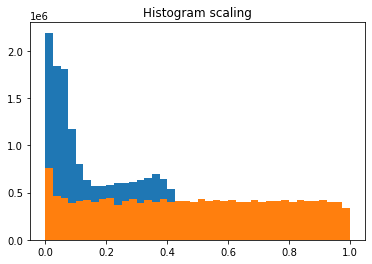

In [ ]:
# adaptie histogram scaling
plt.hist(im.flatten().numpy()/im.max().numpy(), bins = 40)
plt.hist(im.hist_scaled().flatten().numpy(), bins = 40)
plt.title("Histogram scaling") 
plt.show()

### Mean, Median and Max scaling

In [ ]:
#export
@patch
def normalize(t:TensorDicom3D, 
              norm_type = 'mean'):
    "normalizes a 3D Tensor, 0 voxels are not included for normalization"
    if norm_type == 'mean':
        mask = t.ne(0.)
        mean, sd = t[mask].mean(), t[mask].std()
        return (t - mean) / sd
    
    if norm_type == 'median':
        mask = t.ne(0.)
        if mask.view(-1).shape[0] >=2 **16: 
            # resize to large tensor for quantile
            # qunatile takes up to size 2**24, but than takes ~1sec 
            mask = F.interpolate(t[mask].view(-1).unsqueeze(0).unsqueeze(0), 2**16)
        median, iqr = mask.median(), mask.quantile(0.75)-mask.quantile(0.25)
        return (t-median)/iqr
        
    if norm_type == 'max':
        return (t - t.min()) / (t.max() - t.min())


The pixels are now all nearly equally distributed. 

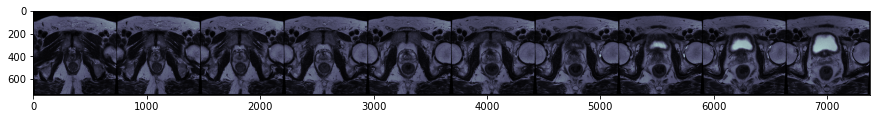

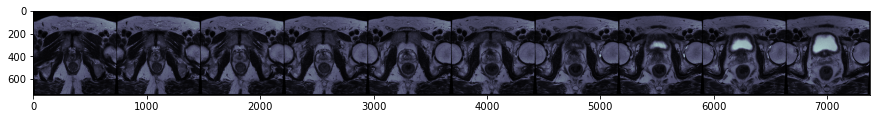

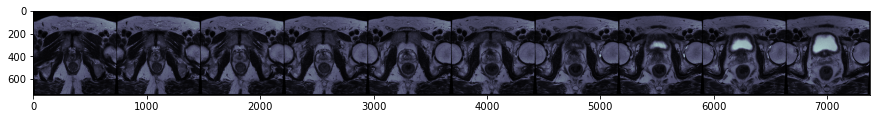

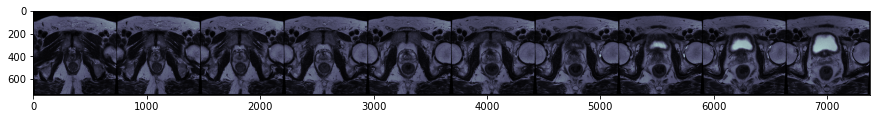

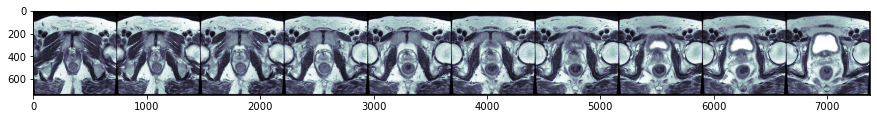

In [ ]:
im1.show()
im1.normalize('mean').show()
im1.normalize('median').show()
im1.normalize('max').show()
im1.hist_scaled().show()

### Comparison to SimpleITK Adaptive Histogram Equalization

`faimed3d` allows for simple intensity corrections through histogram equalization. These implemetations are not as good as the ones provided by SimpleITK but a lot faster. Still, for optimal results using SimpleITK version might be better. 

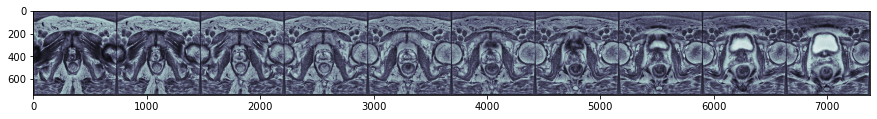

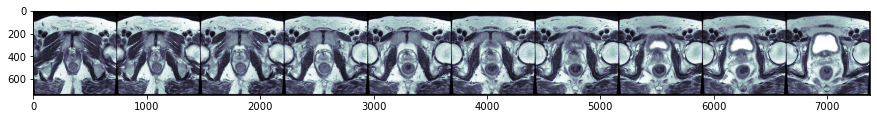

In [ ]:
image = sitk.Cast(im1.as_sitk(), sitk.sitkFloat32)
output = sitk.AdaptiveHistogramEqualization(image, radius=[20]*3, alpha=0.3, beta=0.3) # ~ 30-60 seconds
TensorDicom3D(sitk.GetArrayFromImage(output)).show() 
im1.hist_scaled().show()

### N4 Bias Field Correction
from official [SimpleITK docs](https://simpleitk.readthedocs.io/en/master/link_N4BiasFieldCorrection_docs.html)
> The N4 bias field correction algorithm is a popular method for correcting low frequency intensity non-uniformity present in MRI image data known as a bias or gain field. The method has also been successfully applied as flat-field correction in microscopy data. This method assumes a simple parametric model and does not require tissue classification.

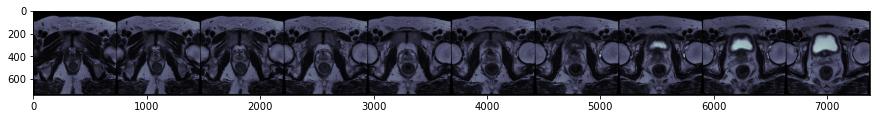

In [ ]:
corrector = sitk.N4BiasFieldCorrectionImageFilter()
corrector.SetMaximumNumberOfIterations([3]*3)
output = corrector.Execute(sitk.Cast(im1.as_sitk(), sitk.sitkFloat32)) # needs float
TensorDicom3D(sitk.GetArrayFromImage(output)).show() #

`faimed3d` provides a wrapper class to apply both N4 Bias Field Correction and Adaptive Histogram Equalization, which basically just simplifies reading the data. 

In [ ]:
# export 
class ImageCorrectionWrapper(object):
    def __init__(self, 
                 n4_max_num_it = 3, 
                 hist_radius = [5,5,5], # radius in format [H x W x D]. Computation time scale ^3 with radius.   
                 hist_alpha  = 0.3, 
                 hist_beta = 0.3, 
                 do_n4 = True, 
                 do_hist = True, 
                 verbose = True):
        store_attr()
        if do_n4: 
            self.corrector = sitk.N4BiasFieldCorrectionImageFilter()

    def __call__(self, orig_file, fn_out=None):
        if isinstance(orig_file, str): 
            if fn_out is None:
                fn_out = self.strip_suffix(fn_in)+'corrected.nii.gz'
            self.convert_string(orig_file, fn_out)
        if isinstance(orig_file, TensorDicom3D):
            if fn_out is None:
                try: fn_out = self.strip_suffix(orig_file.fn)+'corrected.nii.gz'
                except: raise ValueError('Please set a name for the output')
            self._convert(orig_file.as_sitk(), fn_out)
        if self.verbose: 
            print('Coreccted and wrote file to {}'.format(fn_out))
        
    def convert_string(self, fn_in, fn_out):
        im = self.read_image(fn_in)
        self._convert(im, fn_out)

    def _convert(self, im, fn_out):
        if self.do_n4:
            im = self.n4_bias_correction(im)
        if self.do_hist:
            im = self.hist_equal(im)
        sitk.WriteImage(im, fn_out)
    
            
    def n4_bias_correction(self, im):
        self.corrector.SetMaximumNumberOfIterations([self.n4_max_num_it]*3)
        return self.corrector.Execute(im) 
    
    def hist_equal(self, im):
        return sitk.AdaptiveHistogramEqualization(sitk.Cast(im, sitk.sitkInt16), 
                                                  radius=self.hist_radius*3, 
                                                  alpha=self.hist_alpha, 
                                                  beta=self.hist_beta)
    
    def read_image(self, fn):
        "copy of TensorDicom3D.load"
        if isinstance(fn, str): fn = Path(fn)
        if fn.is_dir(): 
            SeriesReader = sitk.ImageSeriesReader()
            dicom_names = SeriesReader.GetGDCMSeriesFileNames(str(fn))
            SeriesReader.SetFileNames(dicom_names)
            im = SeriesReader.Execute()
            return sitk.Cast(im, sitk.sitkFloat32)
        elif fn.is_file():
            return sitk.ReadImage(str(fn), outputPixelType=sitk.sitkFloat32)
        else:
            raise TypeError('the path "{}" is neither a valid directory nor a file'.format(str(fn)))     
            
        
    def strip_suffix(self, fn):
        fn = Path(fn)
        extensions = "".join(fn.suffixes)
        new_fn = str(fn).replace(extensions, '')
        return new_fn+'/' if fn.is_dir() else new_fn

# Rendering 3D Objects

Somtimes the mask is better viewed as 3D object. Rendering is implemented as described in this example: https://scikit-image.org/docs/dev/auto_examples/edges/plot_marching_cubes.html
A faster, more felxible way might be using [ipyvolume](https://github.com/maartenbreddels/ipyvolume/) or [vtk](https://pyscience.wordpress.com/2014/09/11/surface-extraction-creating-a-mesh-from-pixel-data-using-python-and-vtk/). 

To implement 3D rendering for the mask, the TensorMask3D class needs to be expanded

In [ ]:
# export
class TensorMask3D(TensorDicom3D):
    "Base class for 3d Segmentation, inherits from TensorDicom3D"
    
    def get_nonzero_bool(self):
        """
        Identifies non-zero planes alongsinde an axis of a 3D `Tensor`. 
        Returns a 1D boolean `Tensor`. 
        """
        
        z = torch.sum(self.abs(), dim=(1,2)) != 0
        x = torch.sum(self.abs(), dim=(0,2)) != 0
        y = torch.sum(self.abs(), dim=(0,1)) != 0
        return z, x, y
    
    def get_center_id(self, x):
        """
        In a `Tensor` with a sequence of values which are not zero, return the index of the (approx.) central value: 
        
        example:
        x = tensor([0, 0, 0, 1, -3, 1, 4, 1, 0, 0])
        get_center_point(x)
        >>> tensor(5)
        """        
        return x.nonzero().squeeze().median()

    
    def get_strip_idx(self, symmetric):
        """
        Calculated axis-ids to strip zero-planes from `Tensor`
        
        Args:
            symmetric: whether H and W of `Tensor` should be the same after stripping. 
            
        Returns:
            ID of the axis which is closest to the region of interest but still zero
            
        Example: 
            t = torch.zeros(5,9,9)
            t[3,5,5] = 1
            get_strip_idx(t)
            >>> 2,4,4,6,4,6
        """
        
        z, x, y = self.get_nonzero_bool()
        
        center_z = self.get_center_id(z)
        center_x = self.get_center_id(x)
        center_y = self.get_center_id(y)
        
        if symmetric: 
            if x.sum() > y.sum(): y = x
            if y.sum() > x.sum(): x = y
        
        z1, z2 = self._get_idx(center_z, z)
        x1, x2 = self._get_idx(center_x, x)
        y1, y2 = self._get_idx(center_y, y)
                
        return (z1,z2,x1,x2,y1,y2)
        
    def _get_idx(self, c, nonzero_bool):
        min = c - torch.true_divide(nonzero_bool.sum(), 2).ceil()
        max = c + torch.true_divide(nonzero_bool.sum(), 2).ceil()
        if min < 0: 
            max -= min
            min -= min 
        if max > len(nonzero_bool):
            min -= (tensor(len(nonzero_bool)) - max)
            max = tensor(len(nonzero_bool))
        return min.long(), max.long()
    
    def strip(self, pad_x=0, pad_y=0, pad_z=0, pad_xy=None, symmetric = True):
        """
        Reduces a 3D `Tensor` in size through removing 2D planes which are all 0. 
        This is usefull if the segmented region of interest is only a small part
        in the 3D volume (e.g. kidney in an abominal CT).
        
        Args:
            pad_x, pad_y, pad_z: added to margins, to keep a small margin of zero-planes. 
            pad_xy: can be used instead of passing the same number to pad_x and pad_y
            symmetric: whether the resulting size of the `Tensor` should be the same for H and W. 
        
        Returns: 
            A `Tensor` stripped of its zero-margins. 
        
        Procedure: 
            [get strip idx] -> [add padding] -> [strip] 
        """
        
        if hasattr(self, 'strip_idx'): 
            z1,z2,x1,x2,y1,y2 = self.strip_idx      
        else:
            z1,z2,x1,x2,y1,y2 = self.get_strip_idx(symmetric=symmetric)
        
        if pad_xy is not None:
            pad_x, pad_y = pad_xy, pad_xy
            
        def pad(lwr, upr, pad):
            "does only correct to small but not to large value"
            lwr -= pad
            upr  += pad
            if lwr < 0: 
                lwr -= lwr
                upr -= lwr
            return lwr, upr
    
        x1,x2 = pad(x1, x2, pad_x)
        y1,y2 = pad(y1, y2, pad_y)
        z1,z2 = pad(z1, z2, pad_z)
    
        return self._do_strip(x1,x2,y1,y2,z1,z2)
        
    def _do_strip(self, x1,x2,y1,y2,z1,z2):
        stripped_mask = self[z1:z2, x1:x2, y1:y2]
        return TensorMask3D(stripped_mask)
    
    def create_mesh(self, cl, color, alpha):    
        "creates a 3D mesh for a single class in the 3D Tensor"
        
        if self.ndim != 3: raise NotImplementedError('Currently only rank 3 tensors are supported for rendering')
        
        from skimage.measure import marching_cubes_lewiner
        from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    
        im = (self == cl).float()
        
        verts, faces, normals, values = marching_cubes_lewiner(im.permute(1, 2, 0).numpy())
        mesh = Poly3DCollection(verts[faces])
        mesh.set_facecolor(color)
        mesh.set_alpha(alpha)
        return mesh
    
    def show_center_point(self):
        "displays a cross in the center of the mask"
        z, x, y = self.get_nonzero_bool()
        center_z = self.get_center_id(z)
        center_x = self.get_center_id(x)
        center_y = self.get_center_id(y)
        c_val = im.max()+2
        self[center_z, center_x-50:center_x+50, center_y-5:center_y+5] = c_val
        self[center_z, center_x-5:center_x+5, center_y-50:center_y+50] = c_val
        self.show()
    
    def create_mesh_for_classes(self, colors, alpha): 
        "applies `create_mesh` to all classes of the mask"
        classes = self.unique()[1:]
        if colors is None:
            colors = 'bgrcmyw'
            
            if len(classes) > len(colors):
                colors = random.choices(colors, k=len(classes))
            
            else:
                colors = colors[0:len(classes)]
                
        if alpha is None: alpha = (0.5, )*len(classes)     
        if type(alpha) is not tuple: raise TypeError('alpha need to be a tuple.') 
        if len(alpha) == 1: alpha = alpha*len(classes)
        if len(alpha) != len(classes): 
            raise ValueError('Number of classes and number of alpha does not match')
            
        cca = list(zip(classes, colors, alpha))
        
        meshes = [self.create_mesh(cl=cl, color=color, alpha=alpha) for cl, color, alpha in cca]
        return meshes
    
    def render_3d(self, colors=None, alpha = None, symmetric=False):
        "renders the mask as a 3D object and displays it"
        
        im = self.strip(symmetric = symmetric)
        meshes = im.create_mesh_for_classes(colors = colors, alpha = alpha)
        
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        for m in meshes: ax.add_collection3d(m)

        ax.set_xlim(0, im.size(1)) 
        ax.set_ylim(0, im.size(2))  
        ax.set_zlim(0, im.size(0))  
        ax.set_facecolor('k')

        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    def calc_volume(self):
        """
        Calcualtes the volume for a single class in the mask. 
        Calculation relies on correct spacing onformation in the header.
        Results are given in mm**3
        """
        x,y,z = self.metadata['spacing']
        voxel_size = x*y*z
        
        self.volume = {'background': self._calc_vol_per_class(0, voxel_size)}
        self.volume['total_mask_volume'] = self.size(0)*self.size(1)*self.size(2)*voxel_size - self.volume['background']
        
        for c in self.unique()[1:]:
            name = 'class '+str(int(c))
            self.volume[name] = self._calc_vol_per_class(c, voxel_size)
        
        print(self.volume)
         
    def _calc_vol_per_class(self, class_idx, voxel_size):
        "calculates volume of the void, whole mask and for each class in the mask"
        return float((self == class_idx).sum() * voxel_size)
        

/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/ipykernel_launcher.py:127: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19


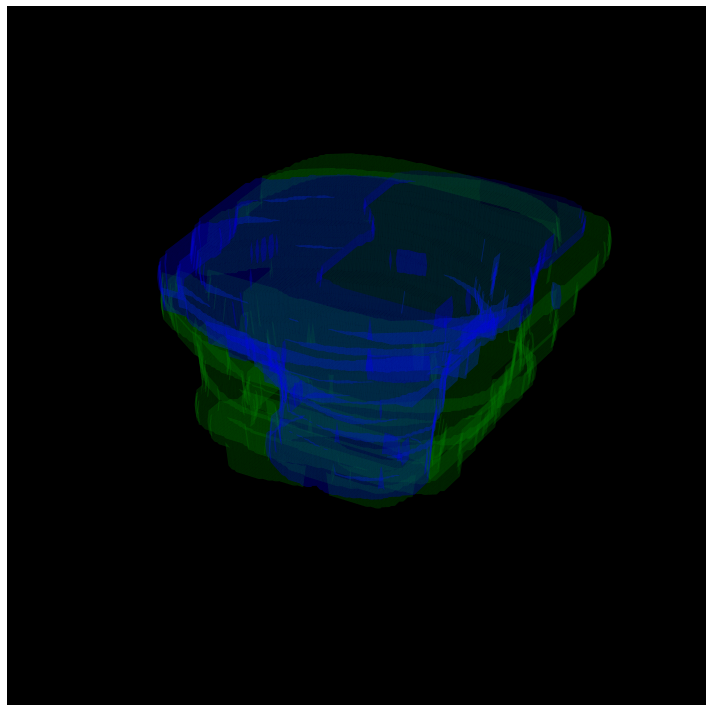

In [ ]:
im  = TensorMask3D.create('/media/ScaleOut/prostata/data/dcm/A0042197734/T2/Annotation/Annotation.nii.gz')       
im.render_3d(alpha = (0.15, 0.15))

In [ ]:
im.calc_volume()

{'background': 3694497.25, 'total_mask_volume': 25414.79155157879, 'class 1': 12753.419921875, 'class 2': 12661.4892578125}


In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 01_basics.ipynb.
Converted 02_transforms.ipynb.
Converted 03_datablock.ipynb.
Converted 04_datasets.ipynb.
Converted 05a_models.modules.ipynb.
Converted 05b_models.alexnet.ipynb.
Converted 05b_models.deeplabv3.ipynb.
Converted 05b_models.densenet.ipynb.
Converted 05b_models.resnet.ipynb.
Converted 05c_models.DynamicUnet.ipynb.
Converted 05c_models.siamese.ipynb.
Converted 05c_models.unet.ipynb.
Converted 05d_models.losses.ipynb.
Converted 06_callback.ipynb.
Converted 99_tools.ipynb.
Converted index.ipynb.
